In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/lfw.zip','r') as zip:
  zip.extractall()


In [5]:
import torch
import glob
import random
import os
import numpy as np

import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from torchvision import transforms

import torch.nn as nn
from torchvision.models import resnet34

import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

Using TensorFlow backend.


In [6]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dir):
        self.dir = dir
        'Initialization'
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((220,220)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

        self.images = glob.glob(dir+'/*/*')
        print(self.images)
        print('font dataset with images', len(self.images))

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

  def __getitem__(self, index):
        cls = self.images[index].split('/')[-2]
        class_dir = os.path.join(self.dir, cls)
        p_img_pth = class_dir+"/"+os.listdir(class_dir)[random.randint(0, len(os.listdir(class_dir))-1)]

        n_img_pth = [x for x in os.listdir(self.dir) if x!=cls]
        class_dir = os.path.join(self.dir, n_img_pth[random.randint(0, len(n_img_pth))-1])
        n_img_pth = class_dir+"/"+os.listdir(class_dir)[random.randint(0, len(os.listdir(class_dir))-1)]
        
        n_img = np.asarray(cv2.imread(n_img_pth,1))
        p_img = np.asarray(cv2.imread(p_img_pth,1))
        a_img = np.asarray(cv2.imread(self.images[index],1))

        #reshaping from [x,y,c] to [c,x,y]
        p_img = np.moveaxis(p_img, -1, 0)
        n_img = np.moveaxis(n_img, -1, 0)
        a_img = np.moveaxis(a_img, -1, 0)

        #converting numpy arrays to tensor        
        p_img = torch.from_numpy(p_img)
        n_img = torch.from_numpy(n_img)
        a_img = torch.from_numpy(a_img)

        p_img = self.transform(p_img)        
        n_img = self.transform(n_img)
        a_img = self.transform(a_img)

        return a_img, p_img, n_img

Data = Dataset('/content/lfw')

['/content/lfw/Gus_Frerotte/Gus_Frerotte_0001.jpg', '/content/lfw/Yasar_Yakis/Yasar_Yakis_0002.jpg', '/content/lfw/Yasar_Yakis/Yasar_Yakis_0004.jpg', '/content/lfw/Yasar_Yakis/Yasar_Yakis_0003.jpg', '/content/lfw/Yasar_Yakis/Yasar_Yakis_0001.jpg', '/content/lfw/Stepan_Demirchian/Stepan_Demirchian_0001.jpg', '/content/lfw/Anders_Ebbeson/Anders_Ebbeson_0001.jpg', '/content/lfw/Anders_Ebbeson/Anders_Ebbeson_0003.jpg', '/content/lfw/Anders_Ebbeson/Anders_Ebbeson_0002.jpg', '/content/lfw/Jim_Bollman/Jim_Bollman_0001.jpg', '/content/lfw/Vaclav_Klaus/Vaclav_Klaus_0002.jpg', '/content/lfw/Vaclav_Klaus/Vaclav_Klaus_0001.jpg', '/content/lfw/Idi_Amin/Idi_Amin_0001.jpg', '/content/lfw/Se_Hyuk_Joo/Se_Hyuk_Joo_0001.jpg', '/content/lfw/Jaouad_Gharib/Jaouad_Gharib_0001.jpg', '/content/lfw/Chang_Jae_On/Chang_Jae_On_0001.jpg', '/content/lfw/Tung_Chee-hwa/Tung_Chee-hwa_0005.jpg', '/content/lfw/Tung_Chee-hwa/Tung_Chee-hwa_0008.jpg', '/content/lfw/Tung_Chee-hwa/Tung_Chee-hwa_0003.jpg', '/content/lfw/Tung_C

In [7]:
train_size = int(0.9*len(Data))
test_size = len(Data) - train_size
trainset,testset = torch.utils.data.random_split(Data,[train_size,test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,shuffle=True, num_workers=2)
#testloader = torch.utils.data.DataLoader(testset, batch_size=8,shuffle=False, num_workers=2)

print(type(trainloader))
print(len(trainloader))

<class 'torch.utils.data.dataloader.DataLoader'>
1489


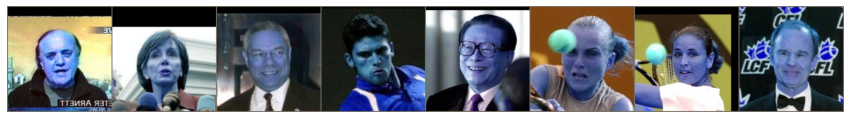

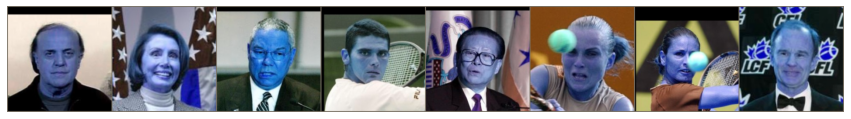

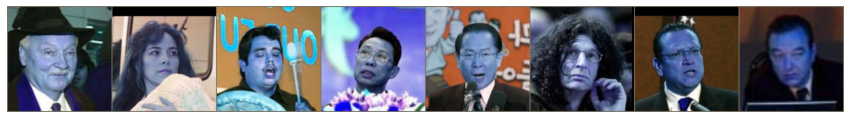

In [8]:
# functions to show an image
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    #Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off')

dataiter = iter(trainloader)
images1, images2,images3 = dataiter.__next__()
#images1, images2, images3 = images1.to(device), images2.to(device), images3.to(device)
# show images
imshow(torchvision.utils.make_grid(images1,nrow=8))
imshow(torchvision.utils.make_grid(images2,nrow=8))
imshow(torchvision.utils.make_grid(images3,nrow=8))

In [0]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [0]:
class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, pretrained=False):
        super (FaceNetModel, self).__init__()
        
        self.model            = resnet34(pretrained)
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(512*7*7, self.embedding_size)
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer     = torch.pow(input, 2)
        normp      = torch.sum(buffer, 1).add_(1e-10)
        norm       = torch.sqrt(normp)
        _output    = torch.div(input, norm.view(-1, 1).expand_as(input))
        output     = _output.view(input_size)
        return output

    def forward1(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        
        x = x.view(-1, torch.prod(torch.tensor(x.shape[1:])).item())
        x = self.model.fc(x)        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha = 10
        self.features = self.features*alpha
        return self.features
    
        
    def forward(self, x1,x2=None,x3=None):
      output1 = None
      output2 = None
      output3 = None
      output1 = self.forward1(x1)
      if(x2!=None):
        output2 = self.forward1(x2)
      if(x3!=None):
        output3 = self.forward1(x3)
      
      if(x2!=None and x3!=None):
        return output1,output2,output3
      return output1
Facemodel = FaceNetModel(128)
#summary(model, input_size=(3,220,220))

criterion = torch.jit.script(TripletLoss())
optimizer = optim.Adam(Facemodel.parameters(), lr=0.001)
if torch.cuda.is_available():
    Facemodel.cuda()

In [0]:
def trainingModel(bs): #27
  Facemodel.train()
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,shuffle=True, num_workers=2)
  dataiter = iter(trainloader)
  images1, images2,images3 = dataiter.__next__()
  for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    #counter = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        input1, input2, input3 = data
        input1, input2, input3 = input1.to(device), input2.to(device), input3.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output1,output2,output3 = Facemodel(input1,input2,input3)
        loss = criterion(output1,output2,output3)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if(i % 100 == 99):
            print('[%d, %5d] loss: %.5f' % (epoch + 1, i + 1, running_loss / i))

In [30]:
trainingModel(27)

[1,   100] loss: 0.66879
[1,   200] loss: 0.55839
[1,   300] loss: 0.50366
[1,   400] loss: 0.46005
[2,   100] loss: 0.37615
[2,   200] loss: 0.34613
[2,   300] loss: 0.33375
[2,   400] loss: 0.32497
[3,   100] loss: 0.26731
[3,   200] loss: 0.27431
[3,   300] loss: 0.27205
[3,   400] loss: 0.27427
[4,   100] loss: 0.25361
[4,   200] loss: 0.25687
[4,   300] loss: 0.26453
[4,   400] loss: 0.26341
[5,   100] loss: 0.26379
[5,   200] loss: 0.24674
[5,   300] loss: 0.24220
[5,   400] loss: 0.24249
[6,   100] loss: 0.24051
[6,   200] loss: 0.23705
[6,   300] loss: 0.22659
[6,   400] loss: 0.22168
[7,   100] loss: 0.25366
[7,   200] loss: 0.22882
[7,   300] loss: 0.22735
[7,   400] loss: 0.22477
[8,   100] loss: 0.20975
[8,   200] loss: 0.20517
[8,   300] loss: 0.20338
[8,   400] loss: 0.20215
[9,   100] loss: 0.18001
[9,   200] loss: 0.17318
[9,   300] loss: 0.16548
[9,   400] loss: 0.16317
[10,   100] loss: 0.16546
[10,   200] loss: 0.15891
[10,   300] loss: 0.16058
[10,   400] loss: 0.15

KeyboardInterrupt: ignored

In [0]:
def Evalution(bs):
  Facemodel.eval()
  testloader = torch.utils.data.DataLoader(testset, batch_size=bs,shuffle=False, num_workers=2)
  dataiter = iter(testloader)
  images1, images2, images3 = dataiter.__next__()
  counter = 0
  total=0
  with torch.no_grad():
    for i, data in enumerate(testloader, 0):
    # get the inputs
      input1, input2, input3 = data
      input1, input2, input3 = input1.to(device), input2.to(device), input3.to(device)
      output1 = Facemodel(input1)
      output2 = Facemodel(input2)
      output3 = Facemodel(input3)

      if(i==0):
        CX = output1.cpu().data.numpy()
        CX = np.vstack((CX,CX))
        CX = CX[1:]
        CX = np.vstack((CX,output2.cpu().data.numpy()))    
        CX = np.vstack((CX,output3.cpu().data.numpy()))    
      else:
        CX = np.vstack((CX,output1.cpu().data.numpy()))    
        CX = np.vstack((CX,output2.cpu().data.numpy()))    
        CX = np.vstack((CX,output3.cpu().data.numpy()))    
  return CX

In [0]:
CX = Evalution(1)

In [46]:
CX[0].shape

(128,)

In [57]:
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

size=int(CX.shape[0]*0.8)
X, y = CX[:size], CX[size+1:]

Xsize = int(X.shape[0]*0.8)
ysize = int(y.shape[0]*0.8)
X_train, X_test, y_train, y_test = X[:Xsize], X[Xsize+1:],y[:ysize], y[ysize+1:]

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_score(y_test, y_pred)

'\nknn.fit(X_train, y_train)\ny_pred = knn.predict(X_test)\naccuracy_score(y_test, y_pred)\n'